In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from math import exp

In [ ]:
# Thiết lập seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [ ]:
# Định nghĩa mô hình PneumoniaResnet
class PneumoniaResnet(nn.Module):
    def __init__(self):
        super(PneumoniaResnet, self).__init__()
        self.network = models.resnet50(pretrained=False)
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 2)  # 2 lớp: NORMAL và PNEUMONIA

    def forward(self, x):
        logits = self.network(x)
        probs = torch.softmax(logits, dim=1)[:, 1]  # Trả về xác suất Pneumonia
        return probs.view(-1, 1)  # Shape [batch_size, 1]

In [ ]:
# Hàm hỗ trợ tính toán Gaussian và lưới
def calc_gaussian(a, std_dev, image_size, positions):
    B = positions.shape[0]
    xa, ya = create_grid(B, image_size)
    xa = xa - positions[:, 0, 0, 0]
    ya = ya - positions[:, 1, 0, 0]
    distance = (xa**2 + ya**2)
    g = a * torch.exp(-distance / std_dev)
    return g.view(B, 1, image_size, image_size)

def create_grid(batch_size, size):
    t = torch.linspace(-1, 1, size).cuda()
    xa, ya = torch.meshgrid([t, t], indexing='ij')
    xa = xa.view(1, size, size).repeat(batch_size, 1, 1)
    ya = ya.view(1, size, size).repeat(batch_size, 1, 1)
    return xa, ya

# Hàm tính blur
def calculate_blur(images, blur_filter_size, sigma=5):
    def gaussian(window_size, sigma):
        gauss = torch.tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
        return gauss / gauss.sum()

    def create_window(window_size, channel, sigma):
        _1D_window = gaussian(window_size, sigma).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
        return window

    window = create_window(blur_filter_size, 3, sigma).cuda()
    pad = nn.ReflectionPad2d(padding=blur_filter_size // 2)
    imgs_pad = pad(images)
    blured_images = F.conv2d(imgs_pad, window, groups=3)
    blur = blured_images - images
    return blur

# Hàm lấy vùng foveation
def get_foveation(foveation_aggregation, foveation_sigma, image_size, positions):
    mask = calc_gaussian(foveation_aggregation, foveation_sigma, image_size, positions)
    return mask

# Hàm chuẩn hóa
def normalize(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x

# Hàm tạo heatmap
def get_heat_maps(foveation_sigma, image_size, scanpaths, forgetting_factor, device, normalization):
    batch_size = scanpaths.shape[0]
    heat_map = torch.zeros((batch_size, 1, image_size, image_size)).to(device)
    for i in range(scanpaths.shape[1]):
        current_positions = scanpaths[:, i, :, :, :]
        current_foveation_mask = get_foveation(1, foveation_sigma, image_size, current_positions)
        heat_map = forgetting_factor[i] * heat_map + current_foveation_mask
    if normalization:
        heat_map = normalize(heat_map)
    return heat_map

In [ ]:
# Định nghĩa lớp FovExWrapper
class FovExWrapper(nn.Module):
    def __init__(self, downstream_model, criterion, target_function, image_size, foveation_sigma, blur_filter_size, blur_sigma, forgetting, heatmap_sigma, heatmap_forgetting, foveation_aggregation=1, device="cuda"):
        super(FovExWrapper, self).__init__()
        self.image_size = image_size
        self.blur_filter_size = blur_filter_size
        self.blur_sigma = blur_sigma
        self.foveation_sigma = foveation_sigma
        self.forgetting = forgetting
        self.foveation_aggregation = foveation_aggregation
        self.internal_representation = None
        self.ones = None
        self.device = device
        self.downstream_model = downstream_model
        self.criterion = criterion
        self.target_function = target_function
        self.heatmap_sigma = heatmap_sigma
        self.heatmap_forgetting = heatmap_forgetting

    def forward(self, x, foveation_positions):
        if self.internal_representation is None:
            raise Exception("First set internal representation with function: initialize_scanpath_generation()")
        foveation_area = get_foveation(self.foveation_aggregation, self.foveation_sigma, self.image_size, foveation_positions)
        current_foveation_area = self.internal_representation + foveation_area
        blurring_mask = torch.clip(self.ones - current_foveation_area, 0, 1)
        applied_blur = self.blur * blurring_mask
        output = self.downstream_model(x + applied_blur)
        return output

    def initialize_scanpath_generation(self, x, batch_size):
        self.internal_representation = torch.zeros((batch_size, 1, self.image_size, self.image_size), device=self.device)
        self.ones = torch.ones((batch_size, 1, self.image_size, self.image_size), device=self.device)
        self.blur = calculate_blur(x, self.blur_filter_size, self.blur_sigma)

    def run_optimization(self, x, labels, scanpath_length, opt_iterations, learning_rate, random_restarts=False):
        batch_size = x.size(0)
        targets = self.target_function(x, labels)
        self.initialize_scanpath_generation(x, batch_size)
        scanpath = []
        loss_history = []

        for step in range(scanpath_length):
            foveation_pos = torch.zeros((batch_size, 2, 1, 1), device=self.device, requires_grad=True)
            best_foveation_pos = torch.zeros((batch_size, 2, 1, 1), device=self.device)
            best_loss = torch.ones((batch_size), device=self.device, dtype=torch.float32) * float("inf")

            for _ in range(opt_iterations):
                output = self(x, foveation_pos)
                loss = self.criterion(output, targets)
                total_loss = loss.mean()
                grad = torch.autograd.grad(total_loss, foveation_pos)[0]
                foveation_pos.data -= torch.sign(grad) * learning_rate
                idxs = (loss.squeeze() < best_loss).squeeze()
                if idxs.sum() > 0:
                    best_loss[idxs] = loss.squeeze()[idxs]
                    best_foveation_pos[idxs] = foveation_pos[idxs]
                if torch.sum(~idxs) > 0:
                    if random_restarts:
                        foveation_pos.data[~idxs] = torch.rand_like(best_foveation_pos.data[~idxs]) * 2 - 1
                    else:
                        foveation_pos.data[~idxs] += torch.rand_like(best_foveation_pos.data[~idxs]) * learning_rate - learning_rate / 2
            current_foveation_mask = get_foveation(self.foveation_aggregation, self.foveation_sigma, self.image_size, best_foveation_pos)
            self.internal_representation = (self.internal_representation * self.forgetting + current_foveation_mask).detach()
            scanpath.append(best_foveation_pos.detach())
            loss_history.append(loss.mean().unsqueeze(0).detach())
            print(f"Step {step}, Loss: {loss.mean().item():.4f}")

        stacked_scanpath = torch.stack(scanpath, dim=1)
        stacked_loss_history = torch.stack(loss_history, dim=1)
        return stacked_scanpath, stacked_loss_history, self.internal_representation

    def generate_explanation(self, x, labels, scanpath_length, opt_iterations, learning_rate, random_restarts=False, normalize_heatmap=True, seed=42):
        set_seed(seed)
        current_scanpaths, current_loss_history, internal_rep = self.run_optimization(x, labels, scanpath_length, opt_iterations, learning_rate, random_restarts)
        heatmap = get_heat_maps(self.heatmap_sigma, self.image_size, current_scanpaths, self.heatmap_forgetting, self.device, normalize_heatmap)
        return heatmap, current_scanpaths, current_loss_history, internal_rep


In [ ]:
# Hàm tiền xử lý ảnh
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0).to("cuda")


In [ ]:
# Đường dẫn
model_path = r"D:\HUS_22001541\PPNCKH\Week2\model\pneumonia_model_weights.pth"
test_dir = "D:/HUS_22001541/PPNCKH/Week2/data/vin_data/test/"

In [ ]:
# Khởi tạo và tải mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model = PneumoniaResnet().to(device)
pytorch_model.load_state_dict(torch.load(model_path, map_location=device))
pytorch_model.eval()
print("Model weights loaded successfully!")

c:\Users\Admin\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model weights loaded successfully!


In [ ]:
# Kiểm tra dự đoán gốc
img_path = os.path.join(test_dir, "Pneumonia", "14c514ed8d3796ed2773638de962a6d6.png")
input_img = preprocess_image(img_path)
with torch.no_grad():
    output = pytorch_model(input_img)  # Xác suất Pneumonia [batch_size, 1]
    logits = pytorch_model.network(input_img)  # Lấy logits từ network để dự đoán nhãn
    probs = torch.softmax(logits, dim=1)
    pred_prob_pneumonia = probs[0, 1].item()
    pred_prob_normal = probs[0, 0].item()
    pred_label_idx = torch.argmax(probs, dim=1).item()
    classes = ["Normal", "Pneumonia"]
    pred_label = classes[pred_label_idx]
    print(f"Dự đoán gốc: {pred_label}")
    print(f"Xác suất Pneumonia: {pred_prob_pneumonia:.4f}, Normal: {pred_prob_normal:.4f}")

Dự đoán gốc: Pneumonia
Xác suất Pneumonia: 0.5642, Normal: 0.4358


In [ ]:
# Nhãn thực tế (Pneumonia = 1)
true_label = torch.tensor([1], dtype=torch.float32).unsqueeze(0).to(device)

In [ ]:
# Định nghĩa criterion và target function
criterion = nn.BCELoss(reduction="none")
def target_function(x, y):
    with torch.no_grad():
        probs = pytorch_model(x)  # Trả về xác suất Pneumonia [batch_size, 1]
        return probs

In [ ]:
# Khởi tạo FovExWrapper
fovex = FovExWrapper(
    downstream_model=pytorch_model,
    criterion=criterion,
    target_function=target_function,
    image_size=224,
    foveation_sigma=0.3,
    blur_filter_size=21,
    blur_sigma=5,
    forgetting=0.05,
    heatmap_sigma=0.3,
    heatmap_forgetting=[1.0] * 5,
    device=device
)

In [ ]:
# Tạo giải thích
heatmap, scanpaths, loss_history, internal_rep = fovex.generate_explanation(
    x=input_img,
    labels=pred_label,
    scanpath_length=5,
    opt_iterations=50,
    learning_rate=0.1,
    random_restarts=True,
    normalize_heatmap=True
)

Step 0, Loss: 0.9571
Step 1, Loss: 0.7788
Step 2, Loss: 0.7401
Step 3, Loss: 0.6930
Step 4, Loss: 0.7448


In [ ]:
# Hàm hoàn tác chuẩn hóa để hiển thị ảnh
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean  # Hoàn tác chuẩn hóa
    return tensor.clamp(0, 1)  # Giới hạn giá trị trong [0, 1]

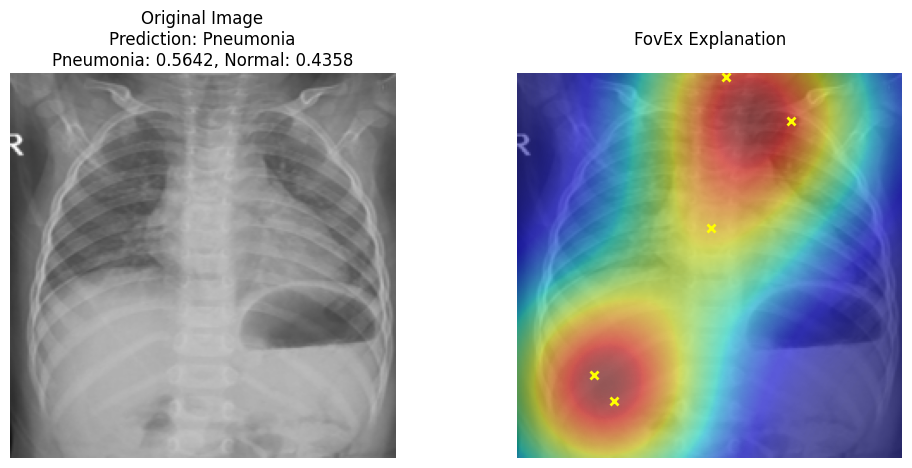

In [ ]:
# Chuẩn bị dữ liệu hiển thị
input_img_display = denormalize(input_img.squeeze().cpu()).permute(1, 2, 0).numpy()

# Hiển thị kết quả
scale = 224 // 2
y = scale * scanpaths[0, :, 0, 0, 0].cpu() + scale
x = scale * scanpaths[0, :, 1, 0, 0].cpu() + scale

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_img_display)
plt.title(f"Original Image\nPrediction: {pred_label}\nPneumonia: {pred_prob_pneumonia:.4f}, Normal: {pred_prob_normal:.4f}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(input_img_display)
plt.imshow(heatmap.squeeze().cpu().numpy(), alpha=0.5, cmap="jet")
plt.plot(x, y, "x", markersize=6, mew=2, color="yellow")
plt.title(f"FovEx Explanation\n")
plt.axis("off")
plt.show()